In [15]:
import os
import sys
import time
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models, datasets

from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import accuracy_score

from src.temperature_scaling import ModelWithTemperature
from src.reliability_diagram import reliability_diagram
from src.focal_loss import FocalLoss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mean = [0.4914, 0.4822, 0.4465]
stdv = [0.247, 0.243, 0.261]

valid_size = 5000

batch_size = 64

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdv),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdv),
])

# Split training into train and validation - needed for calibration
#
# IMPORTANT! We need to use the same validation set for temperature
# scaling, so we're going to save the indices for later
train_set = datasets.CIFAR10("data", train=True, transform=train_transforms, download=True)
valid_set = datasets.CIFAR10("data", train=True, transform=test_transforms, download=False)
test_set = datasets.CIFAR10("data", train=False, transform=test_transforms, download=True)
indices = torch.randperm(len(train_set))
train_indices = indices[:len(indices) - valid_size]
valid_indices = indices[len(indices) - valid_size:]

# Make dataloaders
train_loader = torch.utils.data.DataLoader(train_set, pin_memory=True, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(train_indices))
valid_loader = torch.utils.data.DataLoader(valid_set, pin_memory=True, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(valid_indices))
test_loader = torch.utils.data.DataLoader(test_set, pin_memory=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
resnet = resnet.to(device)

resnet_focal = models.resnet50(pretrained=False)
resnet_focal.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
resnet_focal = resnet_focal.to(device)

In [5]:
def train(model, data_loader, loss_function, seed=None, n_epochs=100, lr=0.1, momentum=0.9, verbose=False) :
    
    model.train()
    
    if seed is not None:
        torch.manual_seed(seed)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)

    # Train model
    for epoch in range(1, n_epochs + 1):
        cum_loss = 0
        for i, (input, target) in enumerate(data_loader):
            # Forward pass
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = loss_function(output, target)
            cum_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer.n_iters = optimizer.n_iters + 1 if hasattr(optimizer, 'n_iters') else 1
        
        if verbose :
              print(f"Epoch {epoch}/{n_epochs} : loss = {cum_loss}")
        scheduler.step()

    
    model.eval()

In [6]:
cross_entropy = nn.CrossEntropyLoss()
focal_loss = FocalLoss()

In [7]:
#Training with cross-entropy loss and temperature scaling
train(resnet, train_loader, cross_entropy, n_epochs=50, verbose=True)
resnet_temp = ModelWithTemperature(resnet)
resnet_temp.set_temperature(valid_loader)

Epoch 1/50 : loss = 2444.5301468372345
Epoch 2/50 : loss = 1517.0241926908493
Epoch 3/50 : loss = 1420.0187147855759
Epoch 4/50 : loss = 1385.1960229873657
Epoch 5/50 : loss = 1302.618453860283
Epoch 6/50 : loss = 1253.345187664032
Epoch 7/50 : loss = 1205.1625771522522
Epoch 8/50 : loss = 1163.1323281526566
Epoch 9/50 : loss = 1134.9101239442825
Epoch 10/50 : loss = 1113.4743074178696
Epoch 11/50 : loss = 1087.536635518074
Epoch 12/50 : loss = 1065.440218925476
Epoch 13/50 : loss = 1039.148171544075
Epoch 14/50 : loss = 1023.3956650495529
Epoch 15/50 : loss = 1010.5337291955948
Epoch 16/50 : loss = 993.2764977216721
Epoch 17/50 : loss = 975.0147355794907
Epoch 18/50 : loss = 961.2169523239136
Epoch 19/50 : loss = 946.6467236280441
Epoch 20/50 : loss = 932.5067938566208
Epoch 21/50 : loss = 914.7790424227715
Epoch 22/50 : loss = 904.3279157280922
Epoch 23/50 : loss = 890.5985983014107
Epoch 24/50 : loss = 872.8987820744514
Epoch 25/50 : loss = 854.2550775408745
Epoch 26/50 : loss = 793

ModelWithTemperature(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [8]:
#Training with focal loss and temperature scaling
train(resnet_focal, train_loader, focal_loss, n_epochs=50, verbose=True)
resnet_focal_temp = ModelWithTemperature(resnet_focal)
resnet_focal_temp.set_temperature(valid_loader)

Epoch 1/50 : loss = 2334.8641661405563
Epoch 2/50 : loss = 1317.100857257843
Epoch 3/50 : loss = 1314.5859034061432
Epoch 4/50 : loss = 1209.2175085544586
Epoch 5/50 : loss = 1038.650810599327
Epoch 6/50 : loss = 935.1968710422516
Epoch 7/50 : loss = 1163.1393523216248
Epoch 8/50 : loss = 1045.8870725631714
Epoch 9/50 : loss = 998.1593328714371
Epoch 10/50 : loss = 959.0443986654282
Epoch 11/50 : loss = 898.956457734108
Epoch 12/50 : loss = 856.5624169707298
Epoch 13/50 : loss = 821.2523034214973
Epoch 14/50 : loss = 787.1917576789856
Epoch 15/50 : loss = 775.4580684304237
Epoch 16/50 : loss = 742.8790618181229
Epoch 17/50 : loss = 725.9598442912102
Epoch 18/50 : loss = 706.3175837397575
Epoch 19/50 : loss = 690.0247797369957
Epoch 20/50 : loss = 681.8973957300186
Epoch 21/50 : loss = 659.2531899809837
Epoch 22/50 : loss = 660.1405118703842
Epoch 23/50 : loss = 1285.3606278896332
Epoch 24/50 : loss = 1161.460886836052
Epoch 25/50 : loss = 1051.681928038597
Epoch 26/50 : loss = 957.8968

ModelWithTemperature(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [9]:
#Saving all models
save = "model/"

torch.save(resnet.state_dict(), os.path.join(save, "resnet_cifar10.ph"))
torch.save(resnet_temp.state_dict(), os.path.join(save, "resnet_temp_cifar10.ph"))
torch.save(resnet_focal.state_dict(), os.path.join(save, "resnet_focal_cifar10.ph"))
torch.save(resnet_focal_temp.state_dict(), os.path.join(save, "resnet_focal_temp_cifar10.ph"))

In [10]:
def plot_calibration(model, loader):

    y_true = []
    y_pred = []
    confidences = []

    print('Computing outputs')
    for _, (input, label) in enumerate(loader):
        out_model = F.softmax(model(input.cuda()),1)
        prob_pred, labels_pred = torch.max(out_model,1)

        y_true += list(label.cpu().detach().numpy())
        y_pred += list(labels_pred.cpu().detach().numpy())
        confidences += list(prob_pred.cpu().detach().numpy())

    print("Accuracy score {}".format(accuracy_score(y_true, y_pred)))

    print('Computing diagram')
    reliability_diagram(np.array(y_true), np.array(y_pred), np.array(confidences), num_bins=10,
        draw_ece=False, draw_bin_importance=False,
        draw_averages=False, title="Reliability Diagram",
        figsize=(6, 6), dpi = 72, return_fig = False)

Computing outputs
Accuracy score 0.6446
Computing diagram


/home/anass/workspace/MAP583/Project-calibration-temperature_scaling/reliability_diagram.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


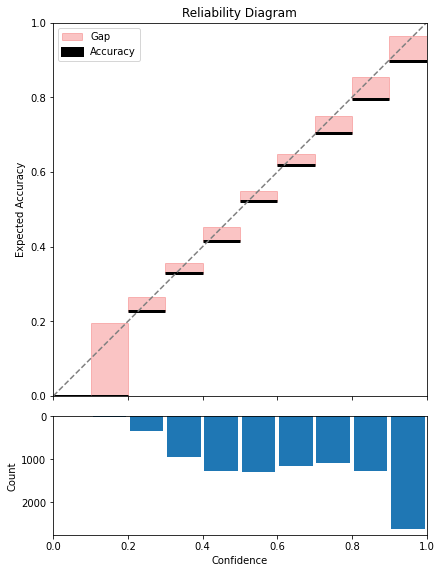

In [11]:
plot_calibration(resnet, test_loader)

Computing outputs
Accuracy score 0.6446
Computing diagram


/home/anass/workspace/MAP583/Project-calibration-temperature_scaling/reliability_diagram.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


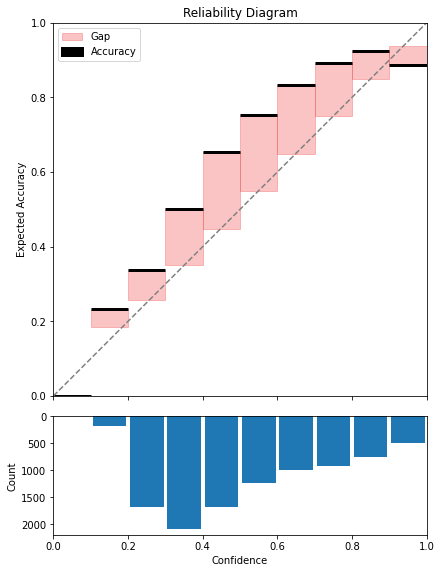

In [12]:
plot_calibration(resnet_temp, test_loader)

Computing outputs
Accuracy score 0.4105
Computing diagram


/home/anass/workspace/MAP583/Project-calibration-temperature_scaling/reliability_diagram.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


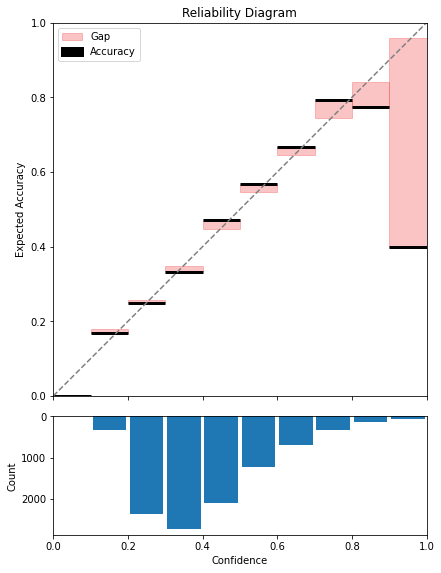

In [13]:
plot_calibration(resnet_focal, test_loader)

Computing outputs
Accuracy score 0.4105
Computing diagram


/home/anass/workspace/MAP583/Project-calibration-temperature_scaling/reliability_diagram.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


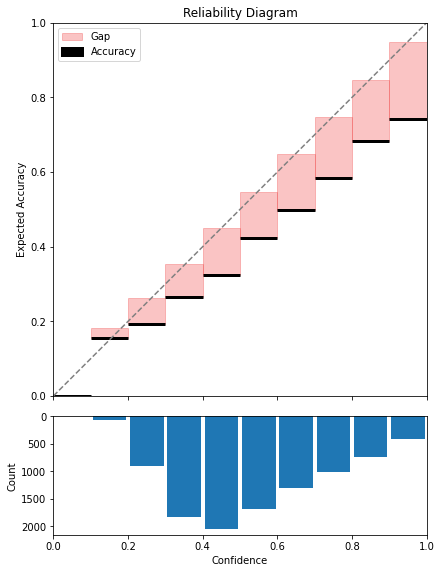

In [14]:
plot_calibration(resnet_focal_temp, test_loader)